In [476]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import random
import time
import math

In [670]:
#import_data
job_sequence = np.array(pd.read_excel("jobshop_final2.xlsx", "sequence1"))
job_amount = job_sequence.shape[0]
machine_amount = job_sequence.shape[1]
processing_time = np.array(pd.read_excel("jobshop_final2.xlsx", "processing time1"))
time_table = np.zeros((machine_amount, job_amount))#record processing time by x-machine, y-job
for i in range(job_amount) :
    for j in range(machine_amount) :
        time_table[job_sequence[i][j]][i] = processing_time[i][j]

print("job_sequence")
print(job_sequence)
print("proccessing time")
print(processing_time)
print("time_table")
print(time_table)

job_sequence
[[2 3 5 4 1 0]
 [0 5 4 1 2 3]
 [1 4 3 0 2 5]
 [1 2 4 3 5 0]
 [4 5 3 0 1 2]
 [5 3 1 4 0 2]]
proccessing time
[[ 6 19  8 13  1  6]
 [22  6  1 16 28  0]
 [25  7 18 26 13  1]
 [21 15 17  0 10 25]
 [28  0 15 16 26  6]
 [24 14 12 22 24  2]]
time_table
[[ 6. 22. 26. 25. 16. 24.]
 [ 1. 16. 25. 21. 26. 12.]
 [ 6. 28. 13. 15.  6.  2.]
 [19.  0. 18.  0. 15. 14.]
 [13.  1.  7. 17. 28. 22.]
 [ 8.  6.  1. 10.  0. 24.]]


In [671]:
#Branch and Bound
#sub_function
def find_array_index(list_, value) :
    for index in range(len(list_)) :
        if list_[index] == value :
            return index

def find_next_machine(selected_node, job_sequence) :#find next node of same job
    index = find_array_index(job_sequence[selected_node[1]], selected_node[0]) + 1
    machine = job_sequence[selected_node[1]][index]
    return (machine, selected_node[1])

def find_previous_machine(selected_node, job_sequence) : #find previous node of same job
    index = find_array_index(job_sequence[selected_node[1]], selected_node[0]) - 1
    machine = job_sequence[selected_node[1]][index]
    return (machine, selected_node[1])

def check_sequence(sequence, node) :
    for i in range(len(sequence)) :
        if sequence[i][0] == node[0] and sequence[i][1] == node[1] : 
            return True
    return False

def min_candidate_machine(candidate_set, time_table, job_sequence, earliest_finish_time_table, selected_set, job_amount) : 
    time = float("inf")
    machine = 0
    for node in candidate_set :
        #check same job time
        if find_array_index(job_sequence[node[1]], node[0]) != 0 :
            previous_node = find_previous_machine(node, job_sequence)
            earliest_finish_time = earliest_finish_time_table[previous_node[0]][previous_node[1]] + time_table[node[0]][node[1]]
        else :
            earliest_finish_time = time_table[node[0]][node[1]]
        #check same machine time
        for job in range(job_amount) :
            if check_sequence(selected_set, (node[0], job)) :
                if earliest_finish_time_table[node[0]][job] + time_table[node[0]][node[1]] > earliest_finish_time :
                    earliest_finish_time = earliest_finish_time_table[node[0]][job] + time_table[node[0]][node[1]]
        if earliest_finish_time < time :
            time = earliest_finish_time
            machine = node[0]
    return machine

def find_sub_candidate_set(i, candidate_set) :
    sub_candidate_set = []
    for node in candidate_set :
        if node[0] == i :
             sub_candidate_set.append(node)
    return sub_candidate_set

def find_Cmax_of_the_node(node, machine_sequence, ancient_map, job_sequence) :
    forward = 0
    backward = 0
    #find backward
    #culminative time of previous node same job
    if find_array_index(job_sequence[node[1]], node[0]) != 0 :#not a first procss in same job   
        previous_node = find_previous_machine(node, job_sequence)
        culminative_time_same_job = earliest_finish_time_table[previous_node[0]][previous_node[1]]
    else :
        culminative_time_same_job = 0
    #culminative time of previous node same machine
    if ancient_map[node[0]][node[1]] != 0 :#not a first procss in same job 
        previous_node = ancient_map[node[0]][node[1]]
        culminative_time_same_machine = earliest_finish_time_table[previous_node[0]][previous_node[1]]
    else :
        culminative_time_same_machine = 0
    backward = max(culminative_time_same_job, culminative_time_same_machine)
    #find forward
    for job in range(job_amount) :
        if check_sequence(selected_set, (node[0], job)) == False : #only can connect with node without selected
            if time_table[node[0]][node[1]] + sum(processing_time[job][find_array_index(job_sequence[job], node[0]):]) > forward :
                forward = time_table[node[0]][node[1]] + sum(processing_time[job][find_array_index(job_sequence[job], node[0]):])
        else :
            if job == node[1] :#node itself
                if sum(processing_time[job][find_array_index(job_sequence[job], node[0]):]) > forward :
                    forward = sum(processing_time[job][find_array_index(job_sequence[job], node[0]):])
    return forward + backward

def adjust_selected_candidate_sets(candidate_set, selected_set, selected_node, job_sequence) :
    selected_set.append(selected_node)
    del candidate_set[candidate_set.index(selected_node)]
    #add next process of same job
    if selected_node[0] != job_sequence[selected_node[1]][-1] :#not lsat process of job
        candidate_set.append(find_next_machine(selected_node, job_sequence))

def update_earliest_finish_time_table(selected_node, time_table, job_sequence, earliest_finish_time_table, selected_set, job_amount) :
    #check same job time 
    if find_array_index(job_sequence[selected_node[1]], selected_node[0]) != 0 :
        previous_node = find_previous_machine(selected_node, job_sequence)
        earliest_finish_time = earliest_finish_time_table[previous_node[0]][previous_node[1]] + time_table[selected_node[0]][selected_node[1]]
    else :
        earliest_finish_time = time_table[selected_node[0]][selected_node[1]]
     #check same machine time
    if ancient_map[selected_node[0]][selected_node[1]] != 0 :
        previous_node = ancient_map[selected_node[0]][selected_node[1]]
        if earliest_finish_time_table[previous_node[0]][previous_node[1]] + time_table[selected_node[0]][selected_node[1]] > earliest_finish_time :
            earliest_finish_time = earliest_finish_time_table[previous_node[0]][previous_node[1]] + time_table[selected_node[0]][selected_node[1]] 
    earliest_finish_time_table[selected_node[0]][selected_node[1]] = earliest_finish_time

    
def jobshop_graph(finish_time_table, start_time_table, machine_amount, job_amount) :
    color = ['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk']
    plt.figure(figsize=(10,5))
    for machine in range(machine_amount) :
        for job in range(job_amount) :
            start_time = int(start_time_table[machine][job])
            finish_time = int(finish_time_table[machine][job])
            plt.plot([start_time, finish_time], [machine, machine],  linewidth = '20', color = color[job])
            plt.xticks(range(0, find_max(finish_time_table)+1, 1))
            plt.yticks([0,1,2,3])
            plt.ylabel("machine", fontsize = 16)
            plt.xlabel("timing", fontsize = 16)
    plt.show()    
        
def update_ancient_map(selected_node, selected_set, ancient_map) :
    for job in range(job_amount) :
        if check_sequence(selected_set, (selected_node[0], job)) == False :
            ancient_map[selected_node[0]][job] = selected_node     
            
def recover_selected_set(selected_set) :
    del selected_set[-1]

def recover_candidate_set(candidate_set, selected_node, job_sequence) :
    if job_sequence[selected_node[1]][-1] != selected_node[0] :
        next_node = find_next_machine(selected_node, job_sequence)
        del candidate_set[candidate_set.index(next_node)]
        candidate_set.append(selected_node)
    else :
        candidate_set.append(selected_node)

def recover_ancient_map(ancient_map, selected_node, selected_set, job_amount) :
    for job in range(job_amount) :
        if check_sequence(selected_set, (selected_node[0], job)) == False :
            ancient_map[selected_node[0]][job] = ancient_map[selected_node[0]][selected_node[1]]
    
        
def branch_and_bound(selected_node, selected_set, candidate_set, final_set, Cmax,  lowest_Cmax, ancient_map, job_sequence, time_table, job_amount, machine_amount, final_finish_time_table) :
    adjust_selected_candidate_sets(candidate_set, selected_set, selected_node, job_sequence)
    node_Cmax = find_Cmax_of_the_node(selected_node, machine_sequence, ancient_map, job_sequence)
    update_earliest_finish_time_table(selected_node, time_table, job_sequence, earliest_finish_time_table, selected_set, job_amount)
    update_ancient_map(selected_node, selected_set, ancient_map)
    if node_Cmax > Cmax :
        Cmax = node_Cmax
    if len(selected_set) == job_amount*machine_amount :
        if Cmax < lowest_Cmax :
            lowest_Cmax = Cmax
            for machine in range(machine_amount) :
                for job in range(job_amount) :
                    final_finish_time_table[machine][job] = earliest_finish_time_table[machine][job]
    else :
        i = min_candidate_machine(candidate_set, time_table, job_sequence, earliest_finish_time_table, selected_set, job_amount)
        sub_candidate_set = find_sub_candidate_set(i, candidate_set)
        for node in sub_candidate_set :
            lowest_Cmax = branch_and_bound(node, selected_set, candidate_set, final_set, Cmax,  lowest_Cmax, ancient_map, job_sequence, time_table, job_amount, machine_amount, final_finish_time_table)
            recover_selected_set(selected_set)
            recover_candidate_set(candidate_set, node, job_sequence)
            recover_ancient_map(ancient_map, node, selected_set, job_amount)
    return lowest_Cmax       

[[ 65.  22.  91. 116.  59. 140.]
 [ 56.  72.  25.  46. 113.  87.]
 [  6. 100. 113.  61. 119. 142.]
 [ 25. 100.  61.  78.  43.  75.]
 [ 55.  36.  35.  78.  28. 109.]
 [ 42.  34. 114.  88.  28.  24.]]


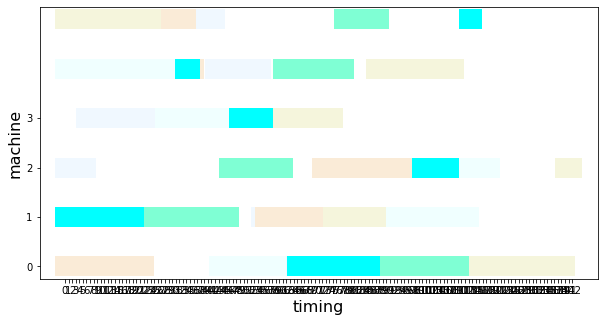

computer_time :  3790.690114736557


In [672]:
#B&B
# parameters
selected_set = []
earliest_finish_time_table = np.zeros((machine_amount, job_amount))
final_finish_time_table = np.zeros((machine_amount, job_amount))
candidate_set = []
ancient_map = [[0 for i in range(job_amount)]for j in range(machine_amount)]#record sequence of same machine
Cmax = 0
lowest_Cmax = float("inf")

#initialize 
for job in range(job_amount) :
    candidate_set.append((job_sequence[job][0], job))
for job in range(job_amount) :
    if sum(processing_time[job]) > Cmax : 
        Cmax = sum(processing_time[job])

# main function
start = time.time()
i = min_candidate_machine(candidate_set, time_table, job_sequence, earliest_finish_time_table, selected_set, job_amount)
sub_candidate_set = find_sub_candidate_set(i, candidate_set)
for node in sub_candidate_set :
    lowest_Cmax = branch_and_bound(node, selected_set, candidate_set, final_set, Cmax,  lowest_Cmax, ancient_map, job_sequence, time_table, job_amount, machine_amount, final_finish_time_table)
    recover_selected_set(selected_set)
    recover_candidate_set(candidate_set, node, job_sequence)
    recover_ancient_map(ancient_map, node, selected_set, job_amount)
print(final_finish_time_table)
start_time_table = final_finish_time_table - time_table
jobshop_graph(final_finish_time_table, start_time_table, machine_amount, job_amount)
end = time.time()
print("computer_time : ", end-start)

In [617]:
#蒙地卡羅search
#sub_function
def find_array_index(list_, value) :
    for index in range(len(list_)) :
        if list_[index] == value :
            return index
        
def find_previous_machine(selected_node, job_sequence) : #find previous node of same job
    index = find_array_index(job_sequence[selected_node[1]], selected_node[0]) - 1
    machine = job_sequence[selected_node[1]][index]
    return (machine, selected_node[1])

def creat_all_node(machine_amount, job_amount) :
    all_node = []
    for machine in range(machine_amount) :
        for job in range(job_amount) :
            all_node.append((machine, job))
    return all_node

def check_sequence(sequence, node) :
    for i in range(len(sequence)) :
        if sequence[i][0] == node[0] and sequence[i][1] == node[1] :
            return True
    return False

def rule_random(selected_set, job_sequence, machine_amount, job_amount) :
    sequence = copy.deepcopy(selected_set)
    while len(sequence) < machine_amount*job_amount :
        random_job = random.randint(0, job_amount-1) 
        for i in range(machine_amount) :
            if check_sequence(sequence, (job_sequence[random_job][i], random_job)) == False:
                sequence.append((job_sequence[random_job][i], random_job))   
                break
    return sequence

def count_Cmax(selected_set, remain_set, machine_amount, job_amount, time_table) :
    accu_machine_time = np.zeros((1, machine_amount))
    finish_table = np.zeros((machine_amount, job_amount))
    sequence = rule_random(selected_set, job_sequence, machine_amount, job_amount)
    for node in sequence :
        if find_array_index(job_sequence[node[1]], node[0]) != 0 : 
            previous_node = find_previous_machine(node, job_sequence)
            time = finish_table[previous_node[0]][previous_node[1]]
        else :
            time = 0
        start_time = max(accu_machine_time[0][node[0]], time)
        finish_table[node[0]][node[1]] = start_time + time_table[node[0]][node[1]]
        accu_machine_time[0][node[0]] = finish_table[node[0]][node[1]]
    return max(accu_machine_time[0])

def update_ucb(N, play_times, Cmax, ucb_forward, ucb_backward, ucb, length, node_place) :
    for place in range(length) :
        if play_times[0][place] > 0 :
            ucb_forward[0][place] = 2*(math.log(N, 2) / play_times[0][place])**0.5
        if place == node_place :
            ucb_backward[0][place] = (-ucb_backward[0][place]*(play_times[0][place] - 1) + Cmax)/ (-play_times[0][place])
        ucb[0][place] = ucb_forward[0][place] + ucb_backward[0][place]
        
def choose_node(selected_set, remain_set, candidate_set, serach_times, machine_amount, job_amount) :
    ucb_forward = np.zeros((1, len(candidate_set)))#根號項
    ucb_backward = np.zeros((1, len(candidate_set)))#平均項
    ucb = np.zeros((1, len(candidate_set)))
    play_times = np.zeros((1, len(candidate_set)))
    for N in range(1, search_times+1) :
        node = candidate_set[find_array_index(ucb[0], max(ucb[0]))]
        play_times[0][find_array_index(candidate_set, node)] = play_times[0][find_array_index(candidate_set, node)] + 1
        temp_remain_set = copy.deepcopy(remain_set)
        temp_remain_set.remove(node)
        temp_selected_set = selected_set + [node]
        Cmax = count_Cmax(temp_selected_set, temp_remain_set, machine_amount, job_amount, time_table)
        update_ucb(N, play_times, Cmax, ucb_forward, ucb_backward, ucb, len(candidate_set), find_array_index(candidate_set, node))
    selected_node = candidate_set[find_array_index(ucb[0], max(ucb[0]))]
    return selected_node

def update_finish_time_table(node, finish_time_table, job_sequence, time_table) :
    if find_array_index(job_sequence[node[1]], node[0]) != 0 : 
        previous_node = find_previous_machine(node, job_sequence)
        previous_time_same_job = finish_time_table[previous_node[0]][previous_node[1]]
    else :
        previous_time_same_job = 0
    previous_time_same_machine = max(finish_time_table[node[0]])
    finish_time_table[node[0]][node[1]] = max(previous_time_same_job, previous_time_same_machine) + time_table[node[0]][node[1]]

def adjust_selected_candidate_sets(candidate_set, selected_set, selected_node, job_sequence, remain_set) :
    selected_set.append(selected_node)
    del candidate_set[candidate_set.index(selected_node)]
    del remain_set[remain_set.index(selected_node)]
    #add next process of same job
    if selected_node[0] != job_sequence[selected_node[1]][-1] :#not lsat process of job
        candidate_set.append(find_next_machine(selected_node, job_sequence))

def jobshop_graph(finish_time_table, start_time_table, machine_amount, job_amount) :
    color = ['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk']
    plt.figure(figsize=(20,5))
    for machine in range(machine_amount) :
        for job in range(job_amount) :
            start_time = int(start_time_table[machine][job])
            finish_time = int(finish_time_table[machine][job])
            plt.plot([start_time, finish_time], [machine, machine],  linewidth = '20', color = color[job])
            plt.xticks(range(0, find_max(finish_time_table)+1, 10))
            plt.yticks([i for i in range(machine_amount)])
            plt.ylabel("machine", fontsize = 16)
            plt.xlabel("timing", fontsize = 16)
    plt.show()

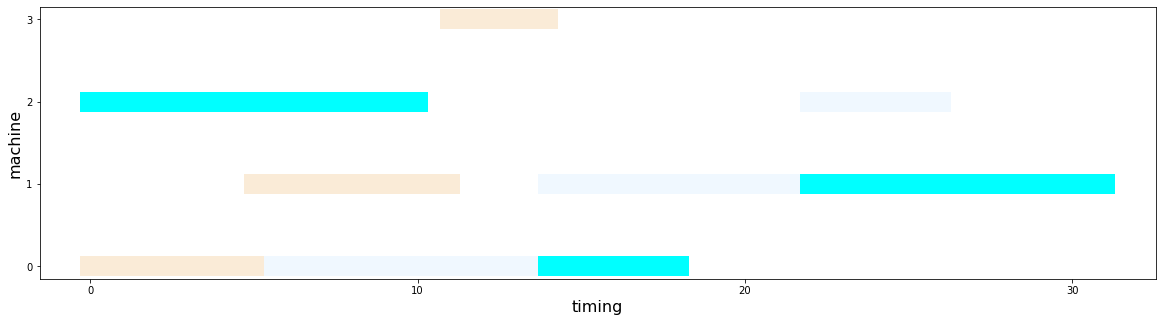

31
[[14.  5. 18.]
 [22. 11. 31.]
 [26. 14. 10.]
 [26. 14. 31.]]
time 1.0057642459869385


In [651]:
#Momte Carlo
#parameter
remain_set = creat_all_node(machine_amount, job_amount)
finish_time_table = np.zeros((machine_amount, job_amount))# fill it all at once after whole sequence determinded
selected_set = []#have sequence concept 
candidate_set = []
search_times = 200

#initialize
for i in range(job_amount) : #initial candidate set
    candidate_set.append((job_sequence[i][0], i))

#main function
start = time.time()
for iteration in range(machine_amount*job_amount) :
    node = choose_node(selected_set, remain_set, candidate_set, search_times, machine_amount, job_amount)
    update_finish_time_table(node, finish_time_table, job_sequence, time_table)
    adjust_selected_candidate_sets(candidate_set, selected_set, node, job_sequence, remain_set)

start_time_table = finish_time_table - time_table
jobshop_graph(finish_time_table, start_time_table, machine_amount, job_amount)
end = time.time()
print(find_max(finish_time_table))
print(finish_time_table)
print("time", end - start)